In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import urllib
import datetime
from tqdm.notebook import tqdm, trange

import tensorflow as tf


In [2]:
#prepare data
@tf.autograph.experimental.do_not_convert
def get_preprocessed_data(batch_size = 32):
  """
      Load and preprocess the data from "Quick, Draw!" into a Tensorflow Dataset

        Args:
            batch_size(int): batch size of the data
  """
  if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
  url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/candle.npy'  
  urllib.request.urlretrieve(url, f'npy_files/candle.npy')

  images = np.load(f'npy_files/candle.npy')

  # limit the amount of images you use for training by setting :F
  train_images = images[:10000]
  # You should also define a samller subset of the images for testing..
  test_images = images[10000:]

  train = tf.data.Dataset.from_tensor_slices(train_images).map(lambda x: (tf.reshape(tf.cast(x, tf.float32), (28,28,1))/128.)-1)
  test = tf.data.Dataset.from_tensor_slices(test_images).map(lambda x: (tf.reshape(tf.cast(x, tf.float32), (28,28,1))/128.)-1)

  train = train.shuffle(2000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
  test = test.shuffle(2000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

  return train,test

In [3]:
## MODEL ##

class Discriminator(tf.keras.Model):
    """Discriminator of the GAN"""

    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        """
        Inititalizes a discriminator

        Args:
            optimizer (tf.keras.optimizer.Optimizer): optimizer for training
        """

        super(Discriminator, self).__init__()

        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.BinaryCrossentropy()

        self.conv = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')
        self.batch = tf.keras.layers.BatchNormalization()
        self.leakyrelu = tf.keras.layers.LeakyReLU()
        self.dropout = tf.keras.layers.Dropout(0.2)

        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same')
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.leakyrelu2 = tf.keras.layers.LeakyReLU()
        self.dropout2 = tf.keras.layers.Dropout(0.2)

        self.flatten = tf.keras.layers.Flatten() 
        self.out = tf.keras.layers.Dense(units=1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.01))
    
    
    def call(self, x, training=False):
        """
        Forward step through model

        Args:
            x (tensor): model input, the generated images of the generator or the real data imges
            training (Bool): whether to train the model

        Returns: 
            float of the likelihood of the image being a real image
        """
        x = self.conv(x)
        x = self.batch(x)
        x = self.leakyrelu(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.leakyrelu2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        x = self.out(x)       

        return x

    def comp_loss(self,real_output, fake_output):
      """compute the loss of the discriminator. 
        The loss of the discriminator is based on how well the discriminator detected fake images as fake and real images as real.
        Computes the binary cross entropy between the generator’s output on fake images and all labels = 0
        and the BCE between the generator’s output on the real images and all labels = 1. 
        Both are added to receive the resulting loss of the discriminator.

      Args:
          real_output: The discriminator’s output on real images
          fake_output: The discriminators’s output on fake images

      Returns:
        discriminator_loss
      """  

      real_loss = self.loss_function(tf.ones_like(real_output), real_output)
      fake_loss = self.loss_function(tf.zeros_like(fake_output), fake_output)
      return real_loss + fake_loss

class Generator(tf.keras.Model):
    """Generator of the GAN"""
    

    def __init__(self, optimizer=tf.keras.optimizers.Adam()):
        """
        Inititalizes a generator

        Args:
            optimizer (tf.keras.optimizer.Optimizer): optimizer for training
        """

        super(Generator, self).__init__()

        self.optimizer = optimizer
        self.loss_function = tf.keras.losses.BinaryCrossentropy()

        self.dense = tf.keras.layers.Dense(units=7*7*128, use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(0.01))
        self.batch = tf.keras.layers.BatchNormalization()
        self.leakyrelu = tf.keras.layers.LeakyReLU()

        self.reshape = tf.keras.layers.Reshape(target_shape=(7, 7, 128))

        self.convtrans  = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.01))
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.leakyrelu2 = tf.keras.layers.LeakyReLU()
        self.dropout = tf.keras.layers.Dropout(0.2)

        self.convtrans2= tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', kernel_regularizer=tf.keras.regularizers.L2(0.01))
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.leakyrelu3 = tf.keras.layers.LeakyReLU()
        self.dropout2 = tf.keras.layers.Dropout(0.2)

        self.out = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01))

    
    def call(self, x, training):
        """
        Call function of the model. Propagates input through the layers.

        Args:
            x (tensor): input to the model
            training (Bool): whether to use training or inference mode. Default: False (inference)

        Returns: a generated Image
        """
        
        x = self.dense(x)
        x = self.batch(x)
        x = self.leakyrelu(x)

        x = self.reshape(x)

        x = self.convtrans(x)
        x = self.batch2(x)
        x = self.leakyrelu2(x)
        x = self.dropout(x)

        x = self.convtrans2(x)
        x = self.batch3(x)
        x = self.leakyrelu3(x)
        x = self.dropout2(x)

        x =self.out(x)
        
        return x
    
    def comp_loss(self,fake_output):
      """compute the loss of the generator. 
      The loss of the generator is estimated by how well the generator was able to fool the discriminator. 
      The more images the discriminator falsely classified as real, the better our generator works.

      Args:
          fake_output: The discriminator’s output on fake images 

      Returns:
        generator_loss
      """  
      return self.loss_function(tf.ones_like(fake_output), fake_output)

In [4]:
## TRAINING ##
def train_step(input, generator, discriminator, batch_size = 32, latent_size = 100):
    """train step 

    Args:
        input(tf.Tensor): input data
        generator(tf.keras.Model): a generator model
        discriminator(tf.keras.Model): a discriminator model
        batch_size(int): batch size of the input data
        latent_size(int): dimensions of the latent space

    Returns:
      gen_loss, dis_loss : loss of generator and discriminator
    """
    
    #the generator is fed with random noise and creates images from it
    noise = tf.random.normal(shape = (batch_size, latent_size))

    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:                       
        
        #get output of the generator and discriminator
        generated_images = generator(noise, training =True) 

        real_output = discriminator(input, training=True)
        fake_output = discriminator(generated_images, training=True)

        # loss functions for generator and discriminator, including the L2 regularization term
        gen_loss = generator.comp_loss(fake_output) + tf.reduce_sum(generator.losses)
        dis_loss = discriminator.comp_loss(real_output, fake_output) + tf.reduce_sum(discriminator.losses)

    #fit the generator and discriminator using gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)                #use same tape
    dis_gradients = dis_tape.gradient(dis_loss, discriminator.trainable_variables)

    generator.optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    discriminator.optimizer.apply_gradients(zip(dis_gradients, discriminator.trainable_variables))

    return gen_loss, dis_loss 

def test(test_data, generator, discriminator,batch_size = 32, latent_size = 100):
    """ test step 

    Args:
        test_data(tf.Tensor): data set on which the test is executed
        generator(tf.keras.Model): a generator model
        discriminator(tf.keras.Model): a discriminator model
        batch_size(int): batch size of the input data
        latent_size(int): dimensions of the latent space

    Returns:
      test_loss
    """

    gen_test_loss_aggregator = []
    dis_test_loss_aggregator = []
    decoded_imgs = []

    for input in test_data: 

        noise = tf.random.normal(shape = (batch_size, latent_size))
        generated_images = generator(noise) 

        real_output = discriminator(input)
        fake_output = discriminator(generated_images)

        gen_sample_test_loss = generator.comp_loss(fake_output)
        dis_sample_test_loss = discriminator.comp_loss(real_output, fake_output)

        gen_test_loss_aggregator.append(np.mean(gen_sample_test_loss.numpy()))
        dis_test_loss_aggregator.append(np.mean(dis_sample_test_loss.numpy()))

        #save prediction images for visualization
        decoded_imgs.append(generated_images.numpy())

    gen_test_loss = np.mean(gen_test_loss_aggregator)
    dis_test_loss = np.mean(dis_test_loss_aggregator)
    
    #print image of test data
    print_img(np.squeeze(decoded_imgs[0]),5)

    return gen_test_loss, dis_test_loss

def train_model(train_data, test_data, generator, discriminator, batch_size, latent_size, epochs=10):
    """
    Utility function to train the GAN.

    Args:
        train_data (tf.data.Dataset): dataset for training
        test_data (tf.data.Dataset): dataset for testing
        generator(tf.keras.Model): a generator model
        discriminator(tf.keras.Model): a discriminator model
        batch_size(int): batch size of the input data
        latent_size(int): dimensions of the latent space
        epochs (int): number of epochs to train 

    """
    #create some random latent vectors before training and feed them through the generator regularly
    eval_noise = tf.random.normal(shape = (batch_size, latent_size))

    #initialize array for loss tracking
    gen_train_losses = []
    dis_train_losses = []
    gen_losses = []
    dis_losses = []

    gen_test_losses = []
    dis_test_losses =[]
    
    for epoch in range(1,epochs):

        print('Epoch:' + str(epoch))

        #training
        for input in train_data:
            gen_train_loss, dis_train_loss = train_step(input,generator, discriminator, batch_size, latent_size)
            gen_losses.append(gen_train_loss)
            dis_losses.append(dis_train_loss)
        gen_train_losses.append(np.mean(gen_losses))
        dis_train_losses.append(np.mean(dis_losses))

        #evaluation on fixed 
        if epoch%2 == 0:
          eval_img = generator(eval_noise)
          np.shape(eval_img)
          print_img(np.squeeze(eval_img), title = "Generated images from the generator on a fixed evaluation point")
        
        # testing
        gen_test_loss,dis_test_loss = test(test_data, generator, discriminator, batch_size, latent_size)
        gen_test_losses.append(gen_test_loss)
        dis_test_losses.append(dis_test_loss)

        visualize_loss(gen_train_losses, dis_train_losses, gen_test_losses, dis_test_losses)

In [5]:
## VISUALIZATION ##
def print_img(output, n=1, title = "Generated images from the generator"):
  """print n images from an array in shape(num_images,height,width)

    Args:
        output(array): output images of an generator
        n(int): number of images to be generated
        titel(string): Titel of the generated plot

  """
  fig = plt.figure()
  
  #tighten the layout for multiple images
  if n==1:
    fig.suptitle(title)
  else: fig.suptitle(title, y=0.7)

  # display first n images in output
  for i, img in enumerate(output[:n]):
    # display single image
    ax = plt.subplot(1, n, i+1)
    plt.imshow(img, cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

def visualize_loss(gen_train_loss, dis_train_loss, gen_test_loss, dis_test_loss):
  """visualize train and test loss

  Args:
      gen_train_loss(array): generator's losses from train step
      dis_train_loss(array): discriminator's losses from train step
      gen_test_loss(array): generator's losses from test step
      dis_test_loss(array): discriminator's losses from train step

  """ 
  plt.figure()
  line1, = plt.plot(gen_train_loss)  
  line3, = plt.plot(dis_train_loss)
  line2, = plt.plot(gen_test_loss)
  line4, = plt.plot(dis_test_loss)
  plt.xlabel("Training steps")
  plt.ylabel("Loss")
  plt.legend((line1,line2, line3,line4),("Generator Training","Discriminator Training","Generator Test", "Discriminator Test"))
  plt.show()

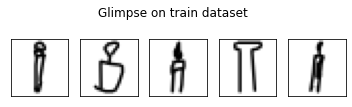

Epoch:1


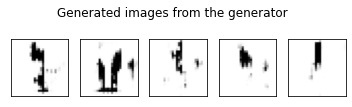

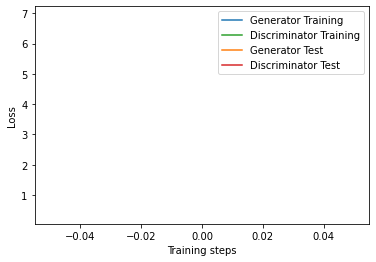

Epoch:2


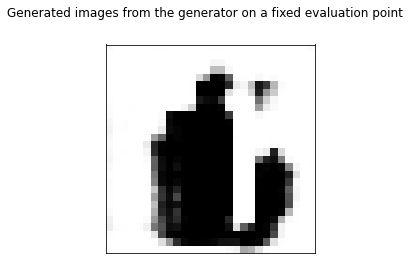

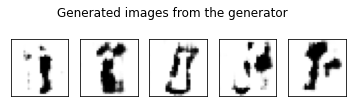

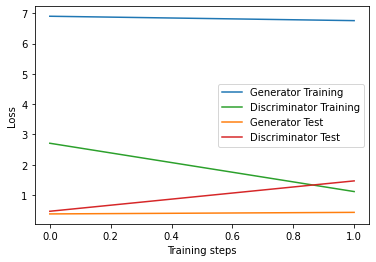

Epoch:3


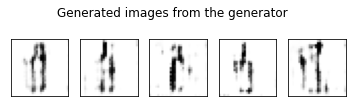

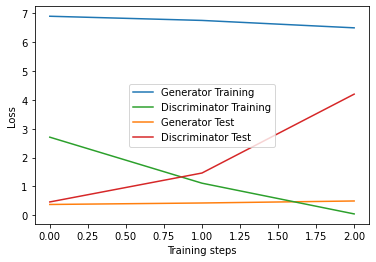

Epoch:4


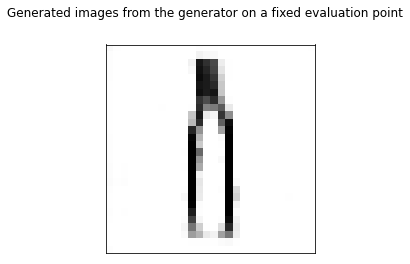

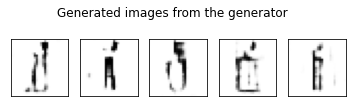

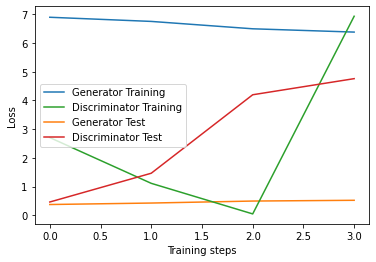

Epoch:5


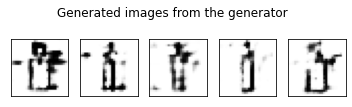

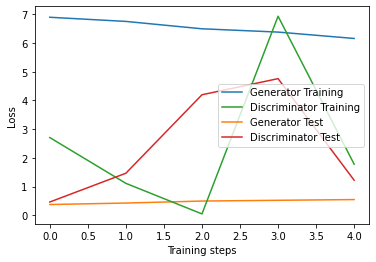

Epoch:6


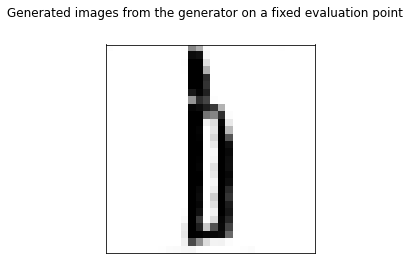

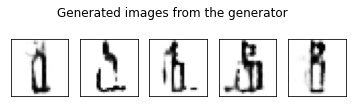

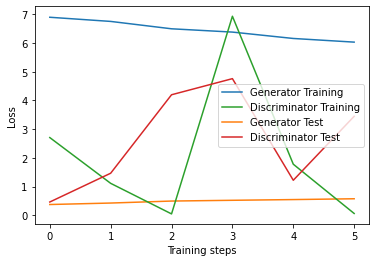

Epoch:7


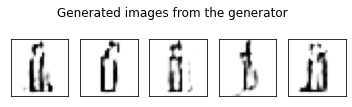

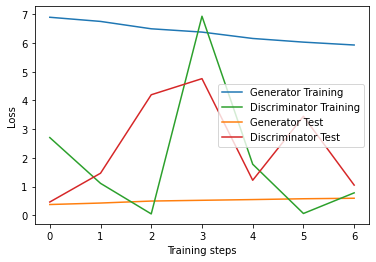

Epoch:8


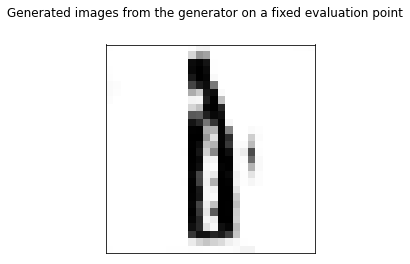

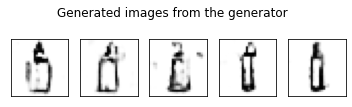

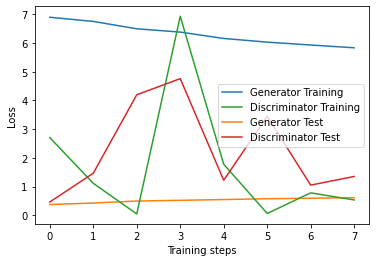

Epoch:9


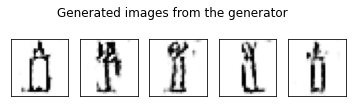

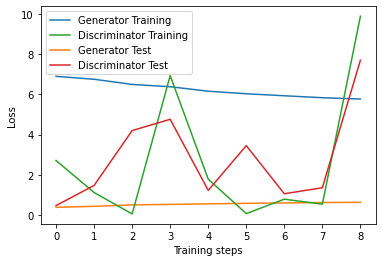

Epoch:10


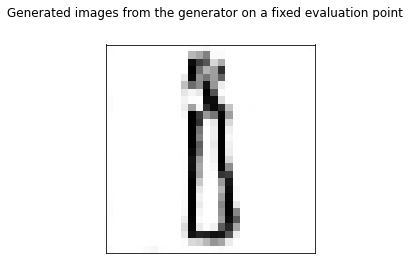

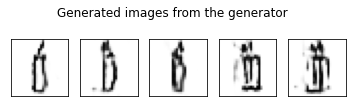

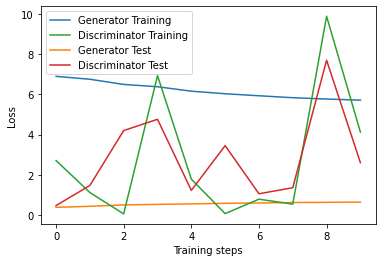

Epoch:11


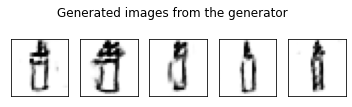

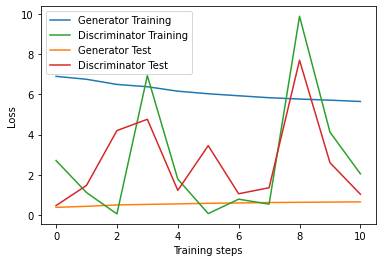

Epoch:12


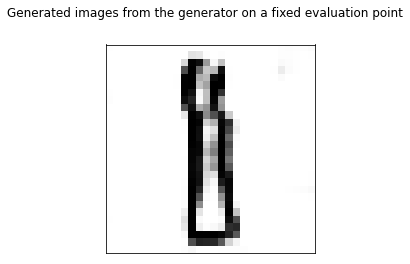

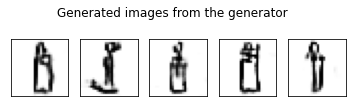

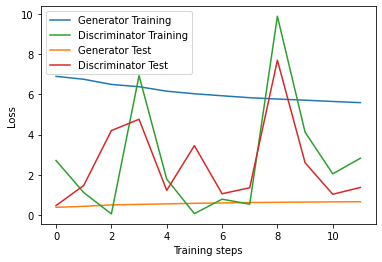

Epoch:13


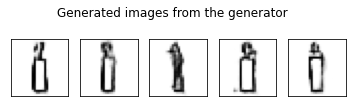

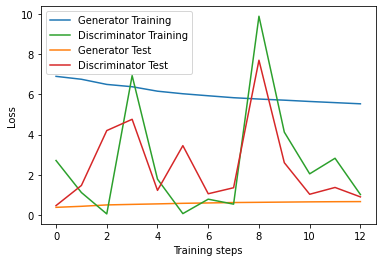

Epoch:14


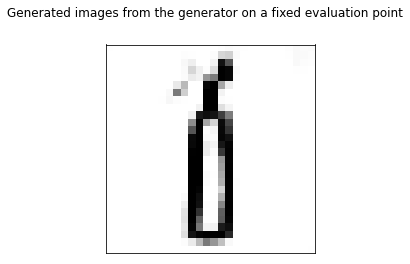

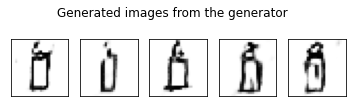

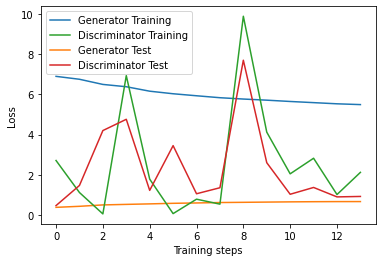

In [6]:
#get and show the data
train_data, test_data = get_preprocessed_data(32)
for images in train_data.take(1):
  print_img(tf.squeeze(images),5, "Glimpse on train dataset")

dis = Discriminator()

gen = Generator()

train_model(train_data, test_data, gen, dis, 32, 100, epochs = 15)

In [7]:
def is_it_christmas(model, month, day):
    """
    Args:
        model (tf.keras.Model): Generator to create candle images
    """
    candles = 0
    #if the given date is not in december or november
    if month-11 < 0:
      print("you still have to wait for the advent")
      candles = 0
    #if the given date is in november
    elif month-11 == 0:
      #if day is at least 1. advent
      if day >= 27:
        candles = 1
      else:
        #it is earlier than 27. november
        print("you still have to wait for the advent")
        candles = 0
    #if the given date is in december
    elif month-11 == 1:
      #if it is before the 2. advent
      if day <= 4:
        candles = 1 
      #if it is before the 3. advent
      elif day <= 11:
        candles = 2
      #if it is before the 4. advent
      elif day <= 18:
        candles = 3
      #if it is before christmas
      elif day <= 24: 
        candles = 4
      #if it is after christmas
      else:
        candels = 5

    noise = tf.random.normal(shape=(candles, 100))
    candles_d = model(noise, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(candles):
        plt.subplot(1, candles, i+1)
        plt.imshow(candles_d[i, :, :, 0], cmap='gray_r')
        plt.axis('off')

What month do you want to check for? Enter a number between 1 and 12
12
What day do you want to check for? Enter a number between 1 and 31
16


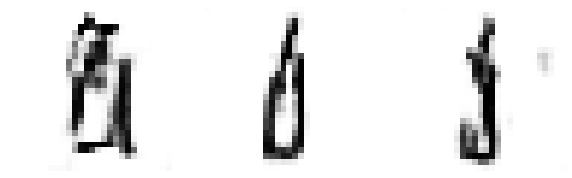

In [9]:
print("What month do you want to check for? Enter a number between 1 and 12")
month = int(input())
print("What day do you want to check for? Enter a number between 1 and 31")
day = int(input())
is_it_christmas(gen, month, day)